In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

config = {'figure.figsize':(12, 4),
          'figure.dpi':72.0 * 2,
          'figure.facecolor':'w',
          'axes.grid':True,
          'grid.linewidth':0.5,
          'grid.linestyle':'--',
          'axes.spines.top':False,
          'axes.spines.bottom':False,
          'axes.spines.left':False,
          'axes.spines.right':False,
          'figure.constrained_layout.use':True}

plt.rcParams.update(config)

# IS-TR-IFM Model

To study shocks in the open and closed IS-TR-IFM models, we can create a Python program to make plots before and after a change in variables.

There's lots of way to do this, but I made a **class**. Classes are like mini-programs. They can save variables, and also hold special functions (called _methods_) that can operate on the stored variables. In our case, we want the class to:

1. Store all the parameters of our model
2. Have some methods to take the parameters and compute the equlibrium values
3. Make some plots

The `IS_TR_IFM_Model` class below implements all this functionality. It's quite long, but actually it's very simple. Mostly it just does the math we saw in TD. There are some special checks to handle floating vs fixed exchange rates. The main method we want to use to `plot_shock`. That will plot the system before and after a change to a requested parameter.

In [2]:
class IS_TR_IFM_Model:
    """
    This class represents an IS-TR-IFM model. It holds parameters, computes equilbrium values, and makes plots.

    The underlying model is:
        Y = C + I + G + TR
        C = a + b * (Y - T)
        I = c + d * Y + e * i
        TR = f + g * Y + g_star * Y_star + h * σ

    With a Taylor rule:
        i = i_bar + β * (Y - Y_bar)

    This class can represent both fixed and floating exchange rate models. This is done by providing or omitting values for 
    i_star (the international interest rate) and sigma (the exchange rate):
        - When only i_star is provided, the model is a flexible exchange rate model. Sigma will be computed endogenously
        - When both i_star and sigma are provided, the model is a fixed exchange rate model. Sigma will be taken as given.
    """

    def __init__(self, a, β, b, c, d, e, f, g, g_star, h,
                 G, T, i_bar, Y_bar, Y_star, i_star=None, sigma=None):
        if i_star is None and sigma is None or sigma is not None and i_star is None:
            raise ValueError('Need to pass i_star (floating exchange rate) or sigma and i_star (fixed exchange rate)')
        
        assert (b + d + g) < 1, f'b + d + g must be less than 1, got {b + d + g}'

        # Demand parameters
        self.a, self.b, self.c, self.d, self.e, self.f, self.g, self.g_star, self.h = a, b, c, d, e, f, g, g_star, h

        # Exogenous variables
        self.G, self.T, self.Y_star = G, T, Y_star

        # Monetary policy parameters
        self.beta, self.i_bar, self.Y_bar = β, i_bar, Y_bar

        # International variables
        self.Y_star, self.i_star, self.sigma = Y_star, i_star, sigma
    
    def compute_A(self):
        a, b, c, f, G, T = self.a, self.b, self.c, self.f, self.G, self.T 
        return a + c + f + G - b * T
    
    def compute_K(self):
        b, d, g = self.b, self.d, self.g
        denom = 1 - (b + d + g)
        return 1 / denom
    
    def taylor_rule(self, Y):
        if self.i_star is not None and self.sigma is not None:
            # Fixed exchange rate -- no TR
            return np.full_like(Y, self.i_star)
        i_bar, beta, Y_bar = self.i_bar, self.beta, self.Y_bar
        return i_bar + beta * (Y - Y_bar)

    def IS_curve(self, Y):
        e, h, g_star, Y_star = self.e, self.h, self.g_star, self.Y_star
        A = self.compute_A()
        K = self.compute_K()
        sigma = self.sigma_equlibrium()
        
        term_1 = Y / e / K
        term_2 = (A + g_star * Y_star + h * sigma) / e
        return term_1 - term_2

    def compute_Y_floating(self):
        i_bar, beta, i_star, Y_bar = self.i_bar, self.beta, self.i_star, self.Y_bar
        return (i_star - i_bar) / beta + Y_bar
        
    def compute_sigma_floating(self, Y):
        if self.sigma is not None:
            return np.full_like(Y, self.sigma)
        A = self.compute_A()
        K = self.compute_K()
        h, e, g, i_star, Y_star = self.h, self.e, self.g, self.i_star, self.Y_star
        
        term_1 = Y / K / h
        term_2 = 1 / h * (A + e * i_star + g * Y_star)
    
        return term_1 - term_2
    
    def i_equlibrium(self):
        if self.i_star is not None:
            return self.i_star

        Y = self.Y_equlibrium()
        Y_star, e, g_star, h = self.Y_star, self.e, self.g_star, self.h
        A = self.compute_A()
        K = self.compute_K()
        
        term_1 = Y / e / K
        term_2 = (A + g_star * Y_star + h * sigma) / e
        return term_1 - term_2
    
    def Y_equlibrium(self):
        Y_bar, i_bar, Y_star, β, e, g_star, h = self.Y_bar, self.i_bar, self.Y_star, self.beta, self.e, self.g_star, self.h
        i_star = self.i_star
        sigma = self.sigma_equlibrium()
        A = self.compute_A()
        K = self.compute_K()

        if i_star is not None and sigma is not None:
            # Fixed exchange rate case 
            return K * (A + e * i_star + g_star * Y_star + h * sigma)
        
        denom = β * e * K - 1
        term_1 = e * K / denom * (β * Y_bar - i_bar)
        term_2 = K / denom * (A + g_star * Y_star + h * sigma)
    
        return term_1 - term_2

    def sigma_equlibrium(self):
        if self.sigma is None:
            # Floating exchange rate
            Y_eq = self.compute_Y_floating()
            sigma = self.compute_sigma_floating(Y_eq)
            return sigma
        else:
            # Fixed exchange rate
            return self.sigma

    def plot_IS_curve(self, Y_grid, ax, **plot_kwargs):
        interest_rates = self.IS_curve(Y_grid)
        ax.plot(Y_grid, interest_rates, **plot_kwargs)

    def plot_TR_curve(self, Y_grid, ax, **plot_kwargs):
        interest_rates = self.taylor_rule(Y_grid)
        ax.plot(Y_grid, interest_rates, **plot_kwargs)

    def plot_IFM_curve(self, Y_grid, ax, **plot_kwargs):
        if self.i_star is None:
            return
        ax.plot(Y_grid, np.full_like(Y_grid, self.i_star), **plot_kwargs)

    def plot_exchange_rate(self, Y_grid, ax, **plot_kwargs):
        ax.plot(Y_grid, self.compute_sigma_floating(Y_grid), **plot_kwargs)

    def plot_IS_TR_equlibrium(self, ax, label=True, text='', label_kwargs=None, **plot_kwargs):
        if label_kwargs is None:
            label_kwargs = {}
        Y_eq = self.Y_equlibrium()
        i_eq = self.i_equlibrium()
        ax.scatter(Y_eq, i_eq, zorder=10, **plot_kwargs)
        if label:
            ax.annotate(text=text, xy=(Y_eq, i_eq), xytext=(Y_eq * 1.01, i_eq * 1.01), **label_kwargs)

    def plot_ER_equlibroium(self, ax, label=True, text='', label_kwargs=None, **plot_kwargs):
        if label_kwargs is None:
            label_kwargs = {}
        Y_eq = self.Y_equlibrium()
        sigma_eq = self.compute_sigma_floating(Y_eq)
        ax.scatter(Y_eq, sigma_eq, zorder=10, **plot_kwargs)
        if label:
            ax.annotate(text=text, xy=(Y_eq, sigma_eq), xytext=(Y_eq * 1.01, sigma_eq * 1.01), **label_kwargs)

    def plot_shock(self, Y_grid, shock_var, shock_size, axes):
        """
        Plot the effects of a shock to a specified model variable or parameter.

        Parameters
        ----------
        Y_grid, numpy.ndarray: 
            An array of output levels (Y) over which to plot the IS-TR-IFM system.
        shock_var, str: 
            The name of the model variable or parameter to be shocked.
        shock_size, float: 
            The size of the shock applied to the specified variable or parameter.
        axes, list: 
            A list of two Matplotlib axes objects for creating the plot. axes[0] is used for the IS-TR-IFM
            plot, and axes[1] is used for the exchange rate plot.

        Returns
        -------
        None

        Notes
        -----
        This method computes and visualizes the changes in the IS-TR-IFM model's equilibrium and exchange rate
        resulting from a shock applied to a specific model variable or parameter. It first calculates the new
        equilibrium values after applying the shock and then plots the initial and post-shock equilibrium curves
        for both the IS-TR-IFM model and the exchange rate.
        """
        old_value = getattr(self, shock_var, None)
        if old_value is None:
            raise ValueError(f'{shock_var} is not a model variable or parameter')
        
        new_value = old_value + shock_size
        
        self.plot_IS_curve(Y_grid, axes[0], c='tab:blue', label='IS Initial')
        self.plot_TR_curve(Y_grid, axes[0], c='tab:orange', label='TR Initial')
        self.plot_IFM_curve(Y_grid, axes[0], c='tab:green', label='IFM Initial')
        self.plot_IS_TR_equlibrium(axes[0], text='A')

        self.plot_exchange_rate(Y_grid, axes[1], c='tab:blue', label='Exchange Rate Initial')
        self.plot_ER_equlibroium(axes[1], text='A')

        setattr(self, shock_var, new_value)

        self.plot_IS_curve(Y_grid, axes[0], c='tab:blue', ls='--', label='IS Shock')
        self.plot_TR_curve(Y_grid, axes[0], c='tab:orange', ls='--', label='TR Shock')
        self.plot_IFM_curve(Y_grid, axes[0], c='tab:green', ls='--', label='IFM Shock')
        self.plot_IS_TR_equlibrium(axes[0], text='B')

        self.plot_exchange_rate(Y_grid, axes[1], c='tab:blue', ls='--', label='Exchange Rate Shock')
        self.plot_ER_equlibroium(axes[1], text='B')

        axes[0].set(title='IS-TR-IFM', ylabel=r'$i$')
        axes[0].legend()
        
        axes[1].set(title='Exchange Rate', ylabel=r'$\sigma$', xlabel='$Y$')

        setattr(self, shock_var, old_value)

## Some Parameters

These are some parameters that I found make OK looking plots. You can experiment with changing them!

In [3]:
# Parameters
# Consumption
a = 0
b  = 0.1

# Investment
c = 1
d = 0.1
e = -0.9

# Trade Balance
f = 0.1
g = 0.01
h = -0.2
g_star = 0.01

# Taylor Rule
β = 0.3
Y_bar = 2
i_bar = 1

# Exogenous variables
i_star = 1.265
Y_star = 1
Y_bar = 1
T = 0.3
G = 1.3
sigma = 0.1

# Analysis

## Fixed Exchange Rates

To make a fixed exchange rate model, we have to give a value for sigma.

In [4]:
fixed_exchange_mod = IS_TR_IFM_Model(a, β, b, c, d, e, f, g, g_star, h, G, T, i_bar, Y_bar, Y_star, sigma=2, i_star=1.2)

### Expansionary Fiscal Policy

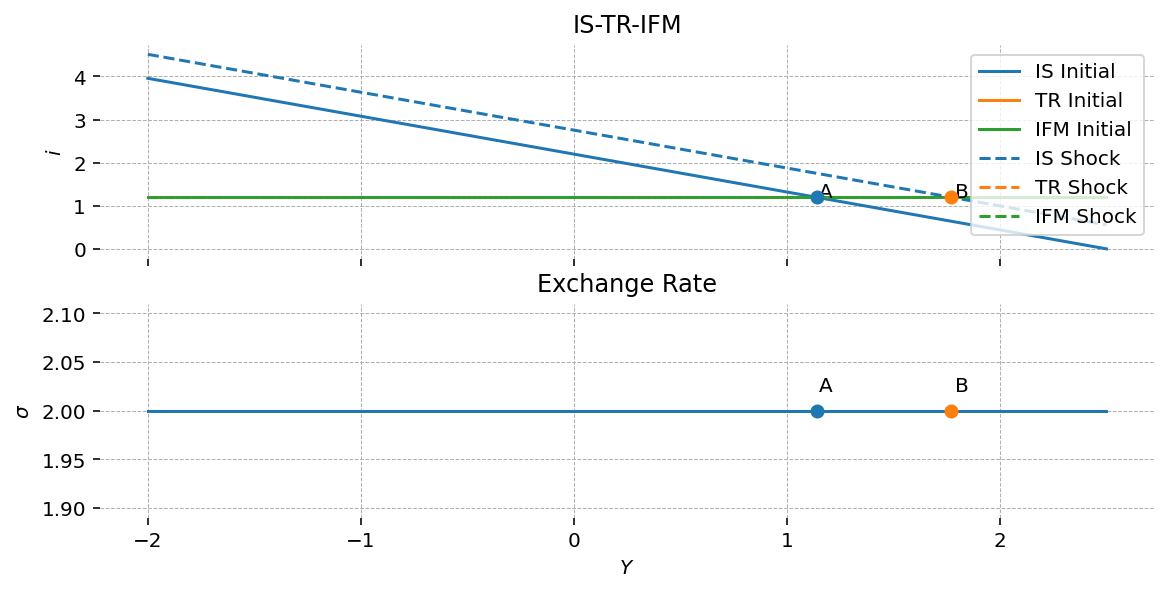

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(8,4), dpi=144, sharex=True)
Y_grid = np.linspace(-2, 2.5, 100)
fixed_exchange_mod.plot_shock(Y_grid, 'G', 0.5, ax)


### Anti-Inflationary Monetary Policy

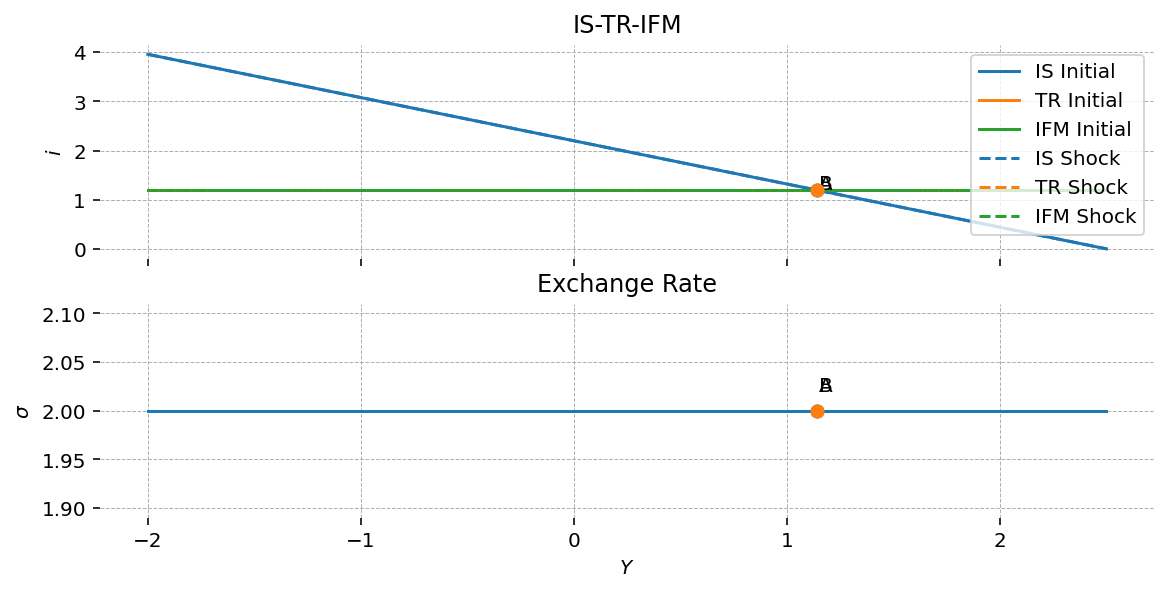

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(8,4), dpi=144, sharex=True)
Y_grid = np.linspace(-2, 2.5, 100)
fixed_exchange_mod.plot_shock(Y_grid, 'i_bar', 0.5, ax)


## Floating Exchange Rate

For the floating case, don't give a sigma value.

In [7]:
floating_exchange_mod = IS_TR_IFM_Model(a, β, b, c, d, e, f, g, g_star, h, G, T, i_bar, Y_bar, Y_star, i_star=1.2)

### Expansionary Fiscal Policy

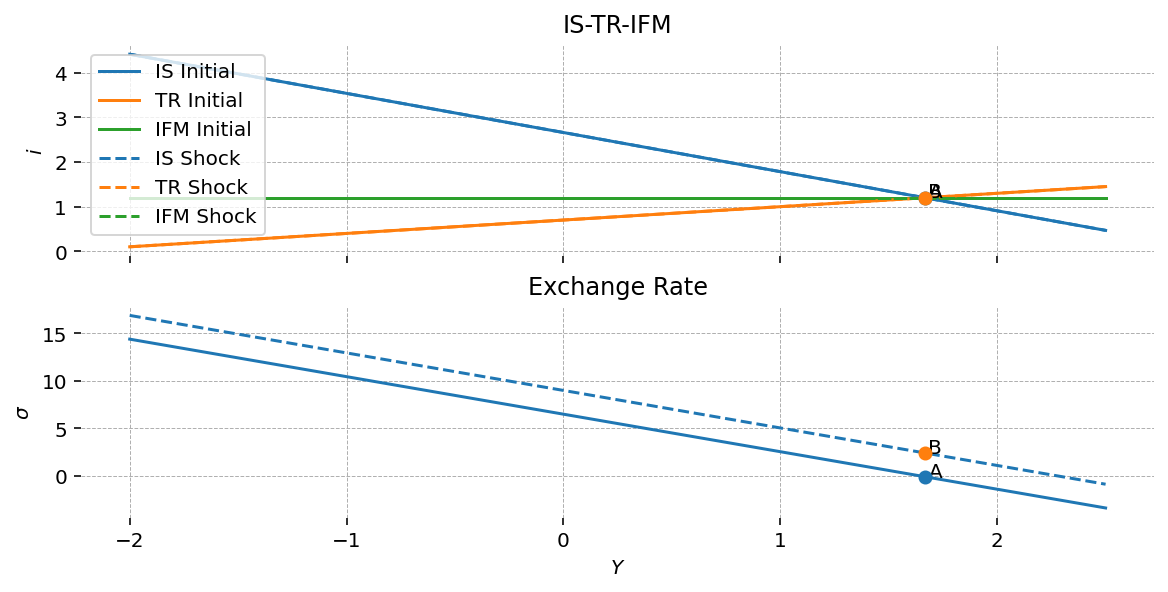

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(8,4), dpi=144, sharex=True)
Y_grid = np.linspace(-2, 2.5, 100)
floating_exchange_mod.plot_shock(Y_grid, 'G', 0.5, ax)

### Anti-Inflationary Monetary Policy

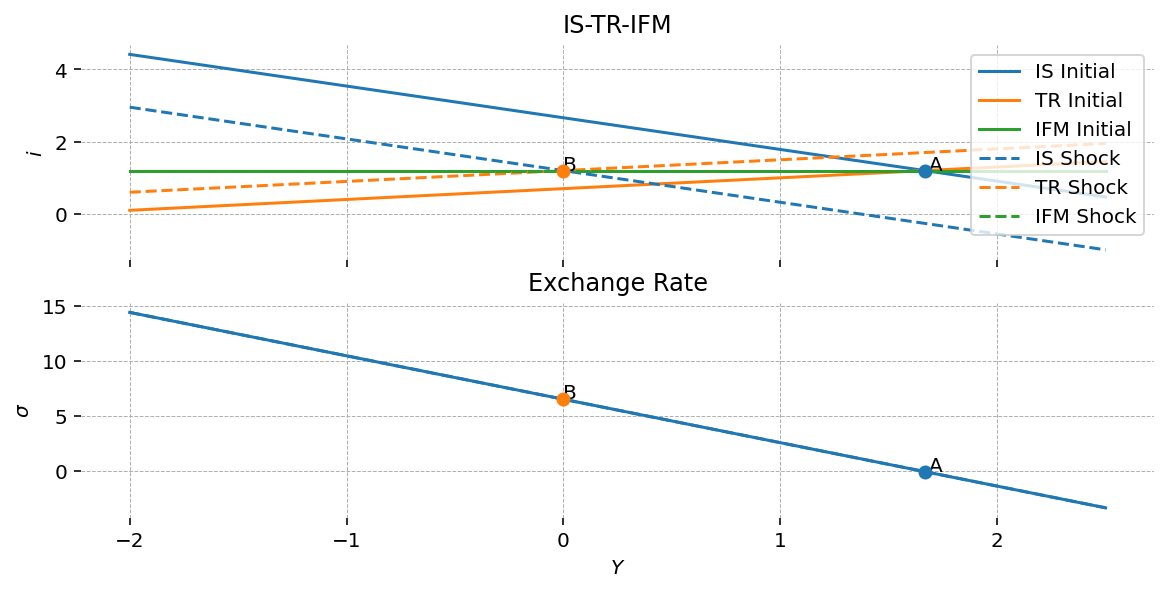

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(8,4), dpi=144, sharex=True)
Y_grid = np.linspace(-2, 2.5, 100)
floating_exchange_mod.plot_shock(Y_grid, 'i_bar', 0.5, ax)